In [1]:
from pathlib import Path
from IPython.display import HTML, display
import os
import base64
import shutil

58 tests (344 questions) already have metadatas.
Test ID: 5f03dfb4-088d-48ae-a756-a83d372e0c94


Q,question.png,answer.png
Q1,,
Q2,,
Q3,,
Q4,,
Q5,,
Q6,,
Q7,,

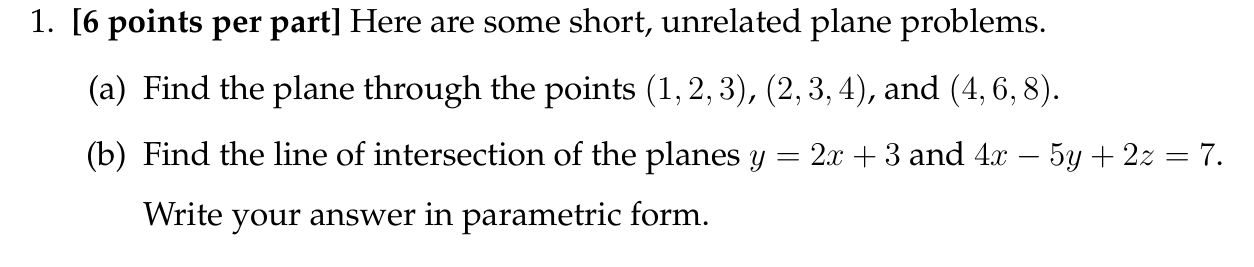
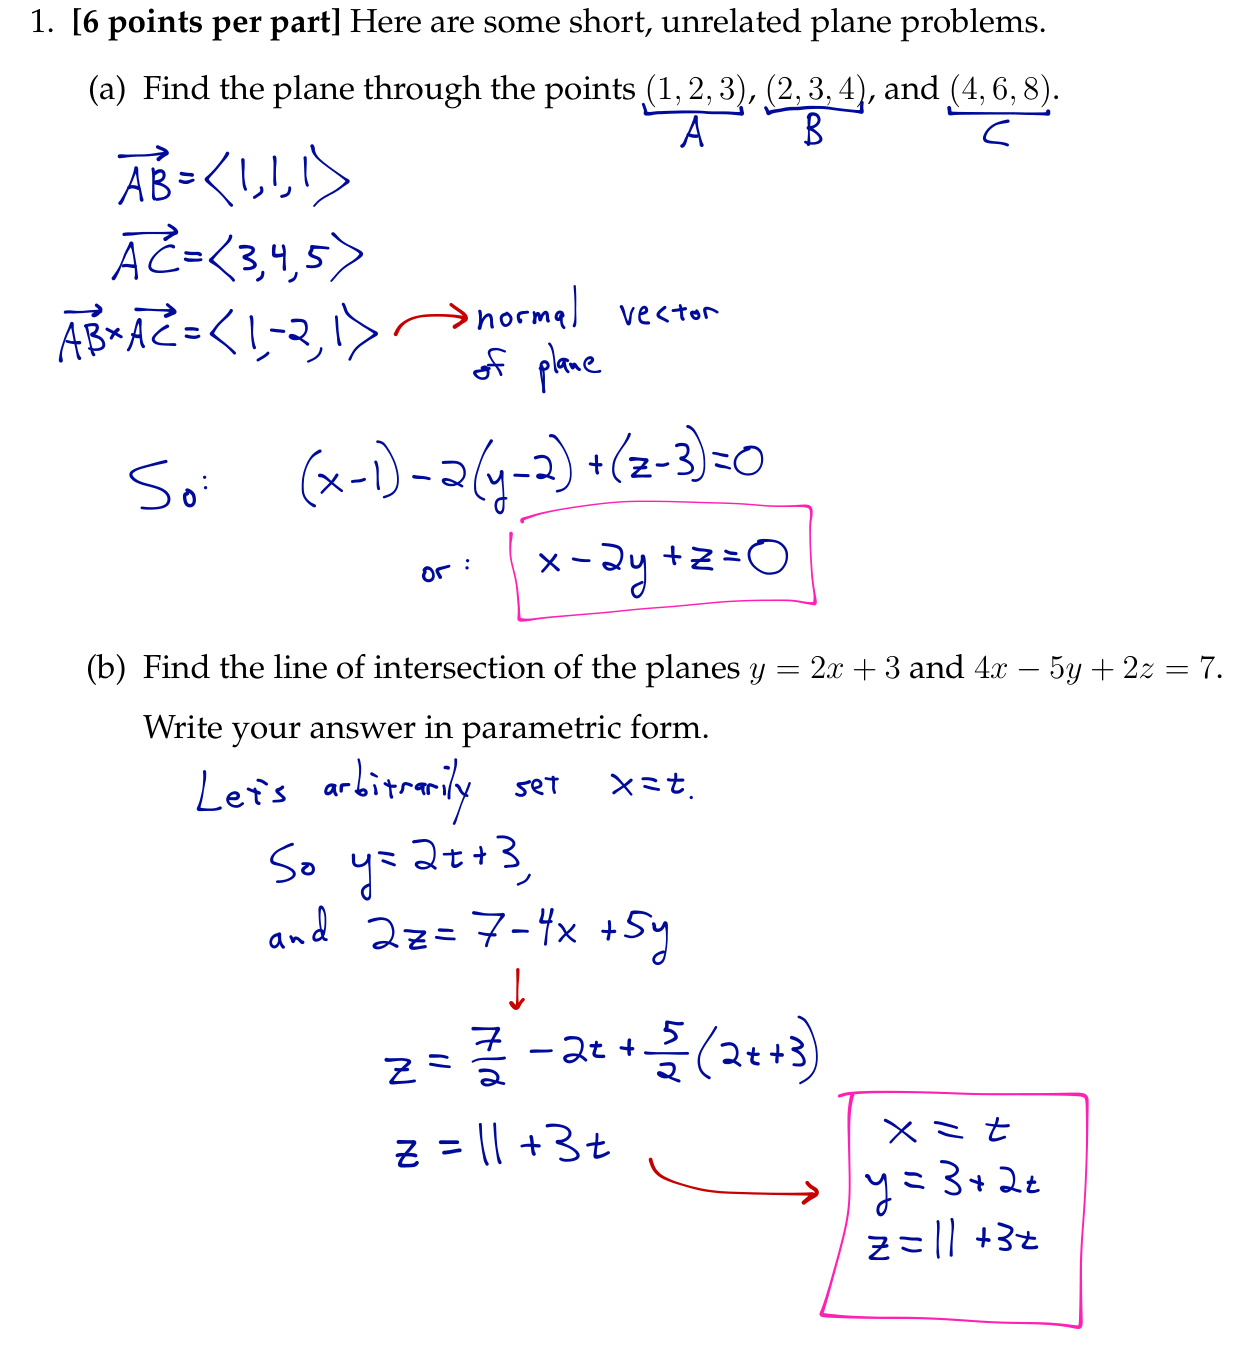
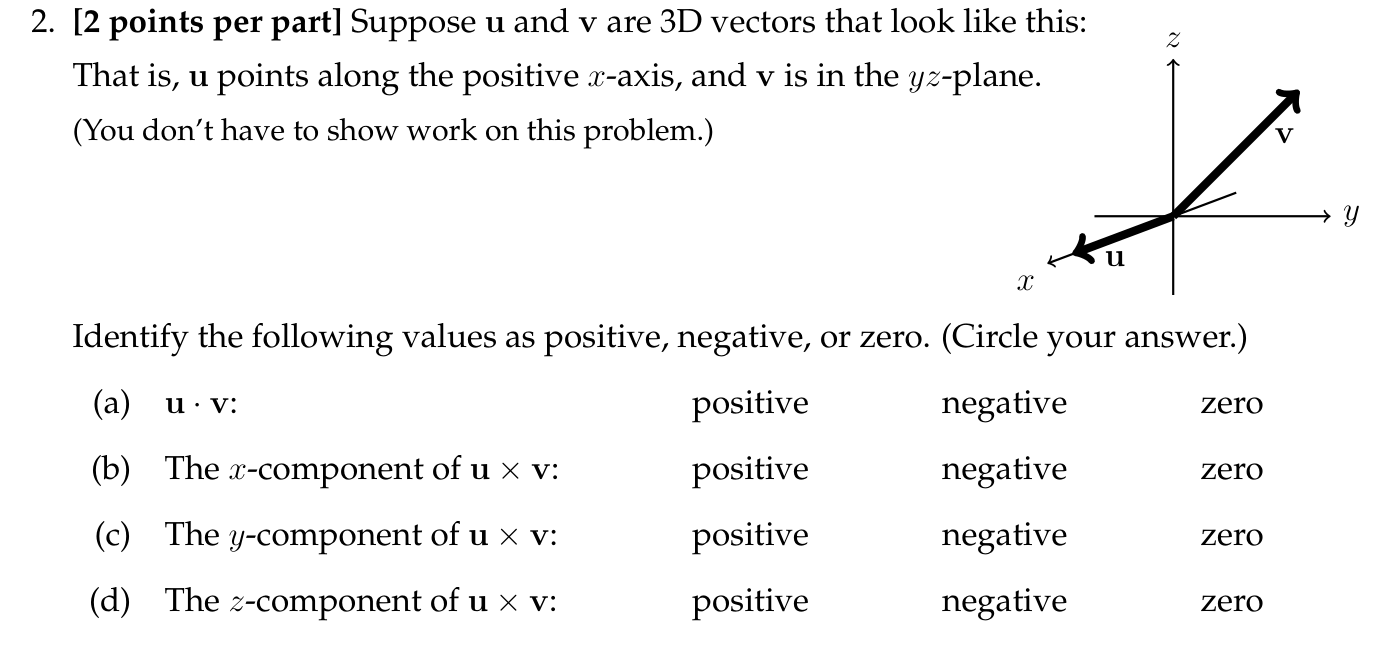
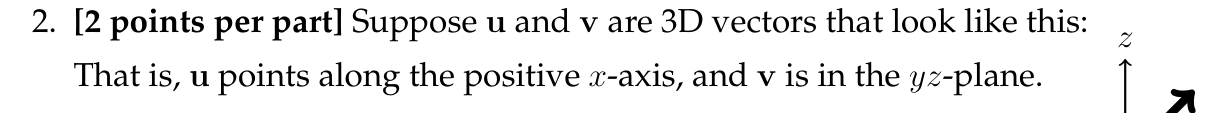
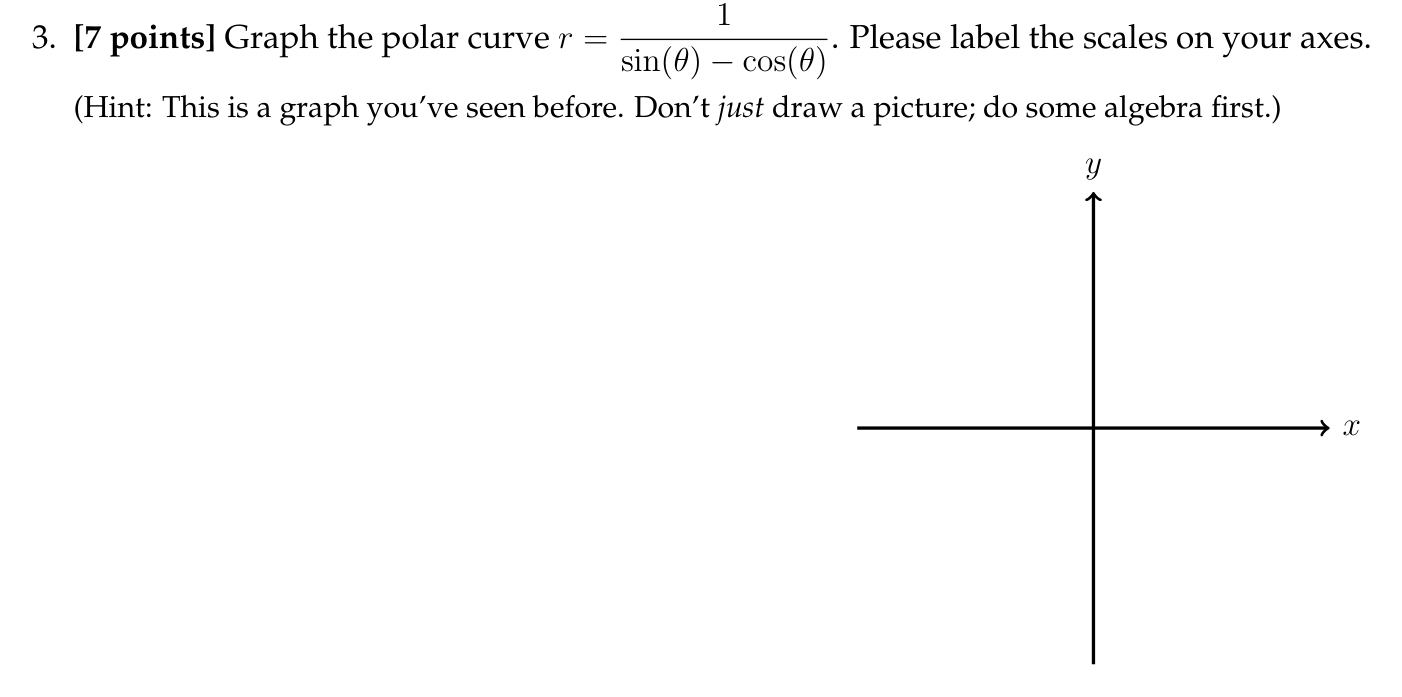
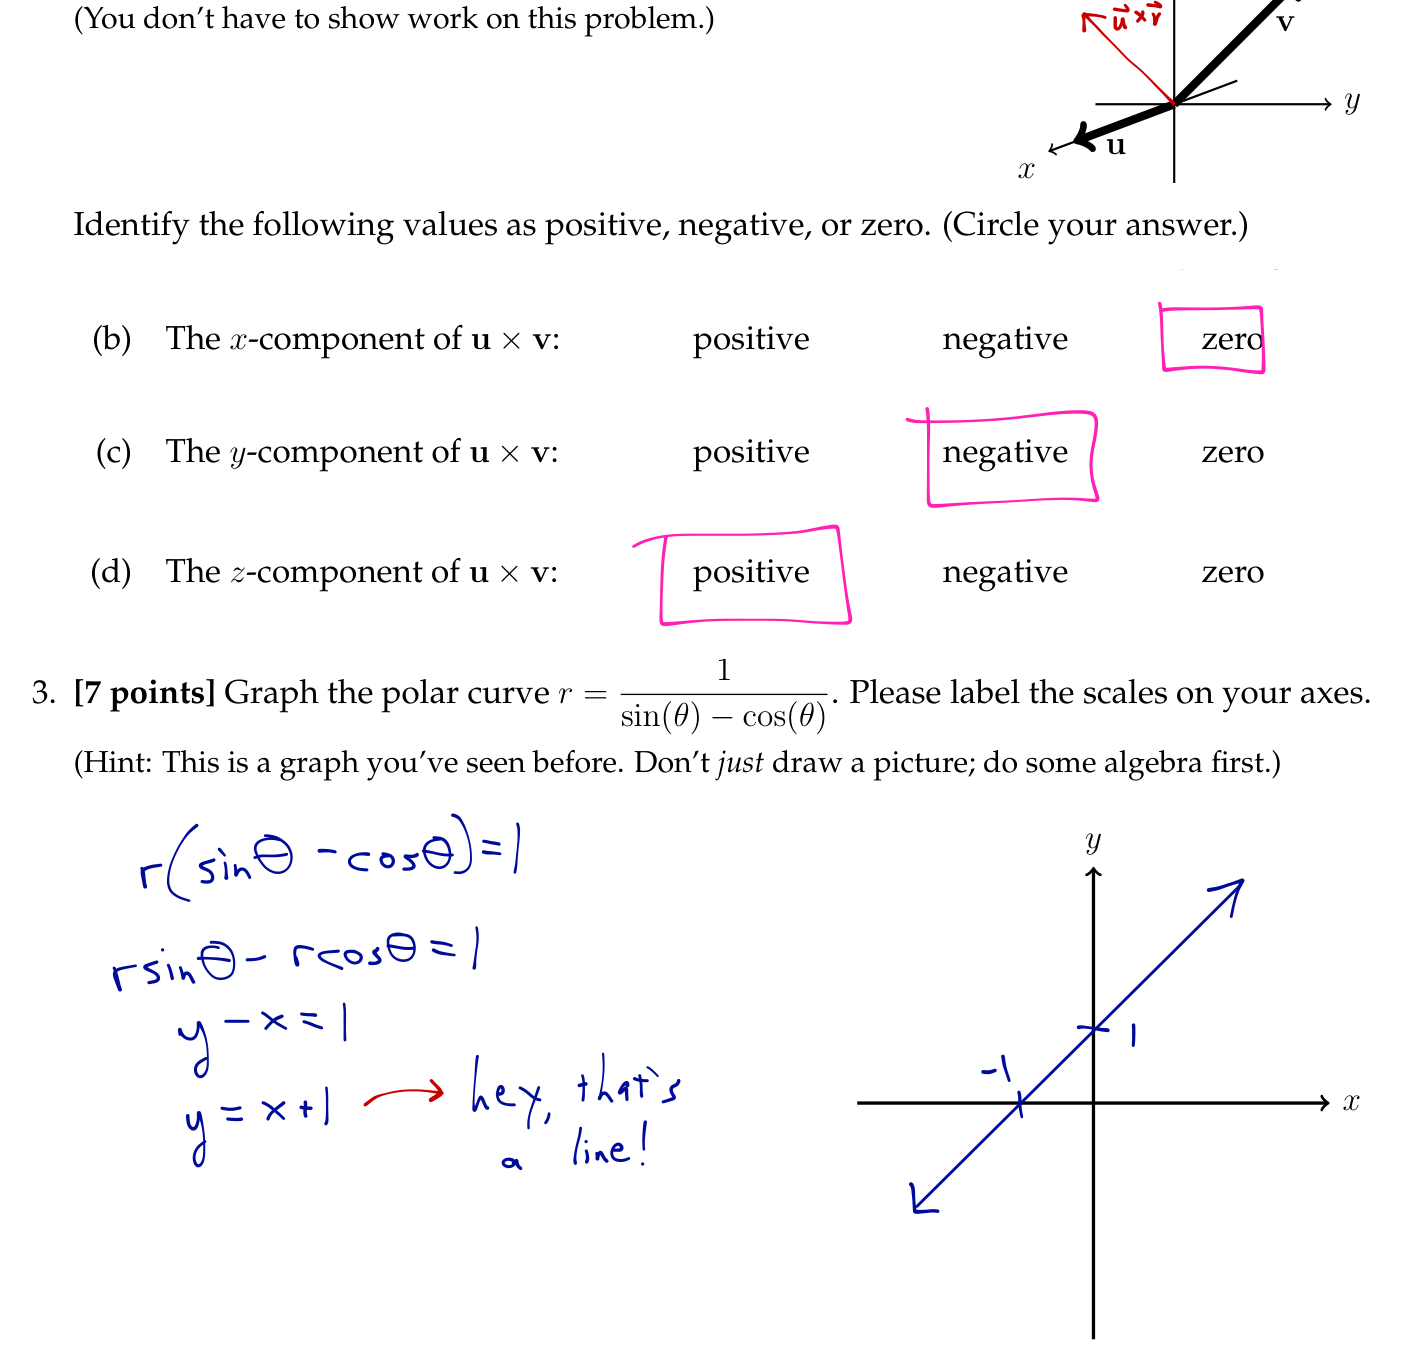
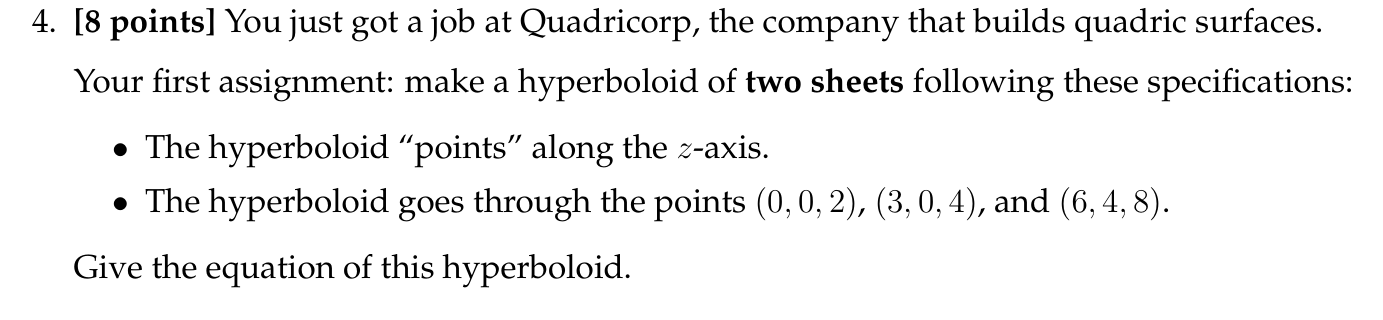
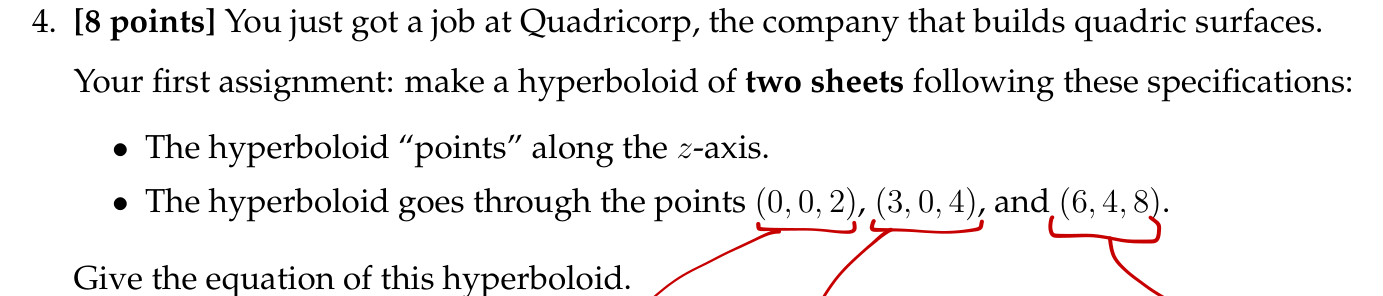
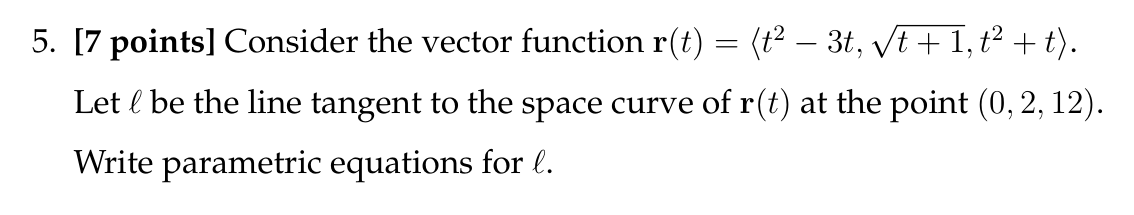
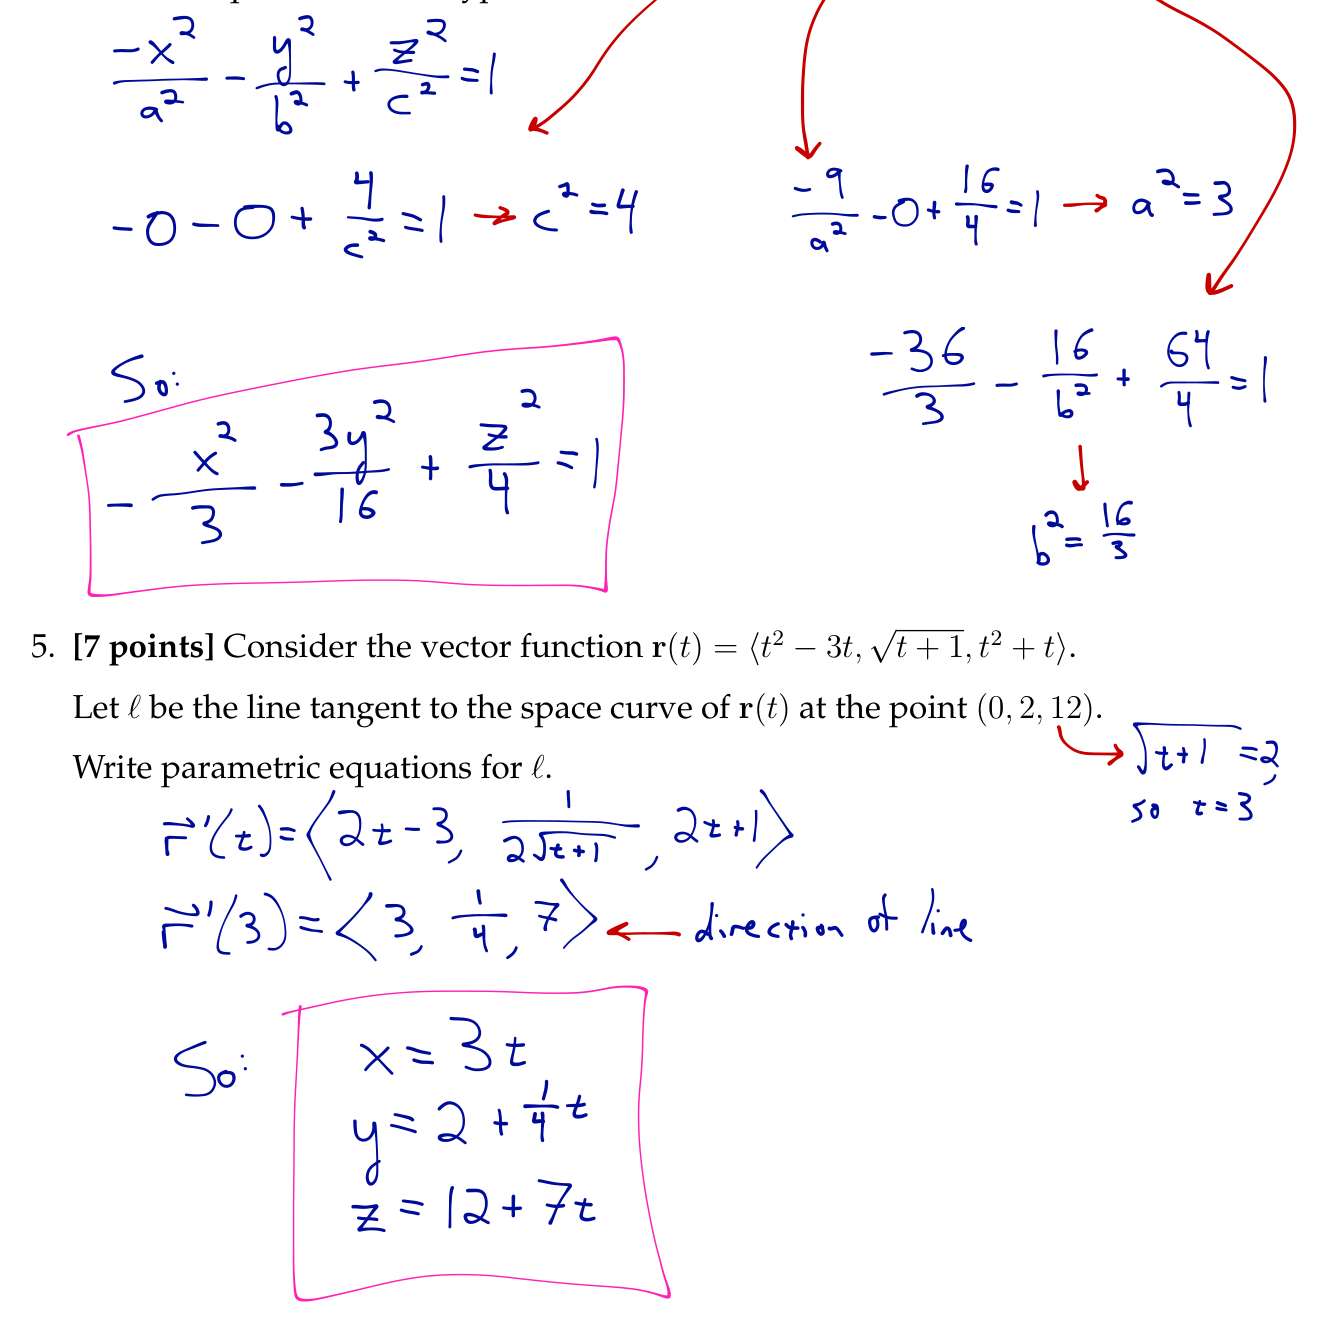
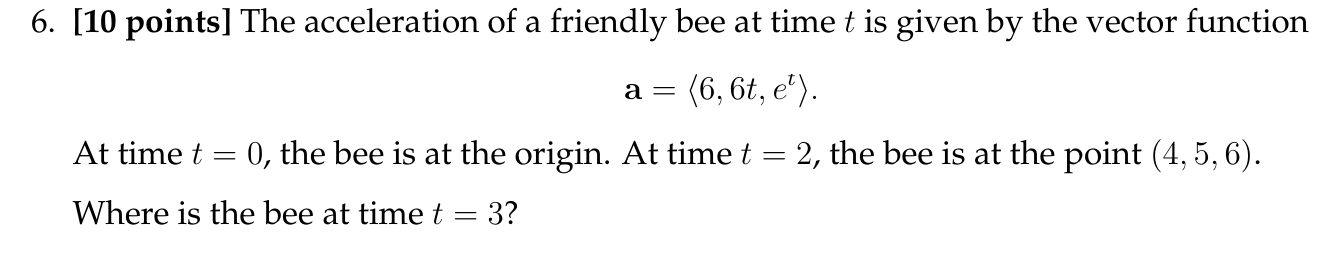
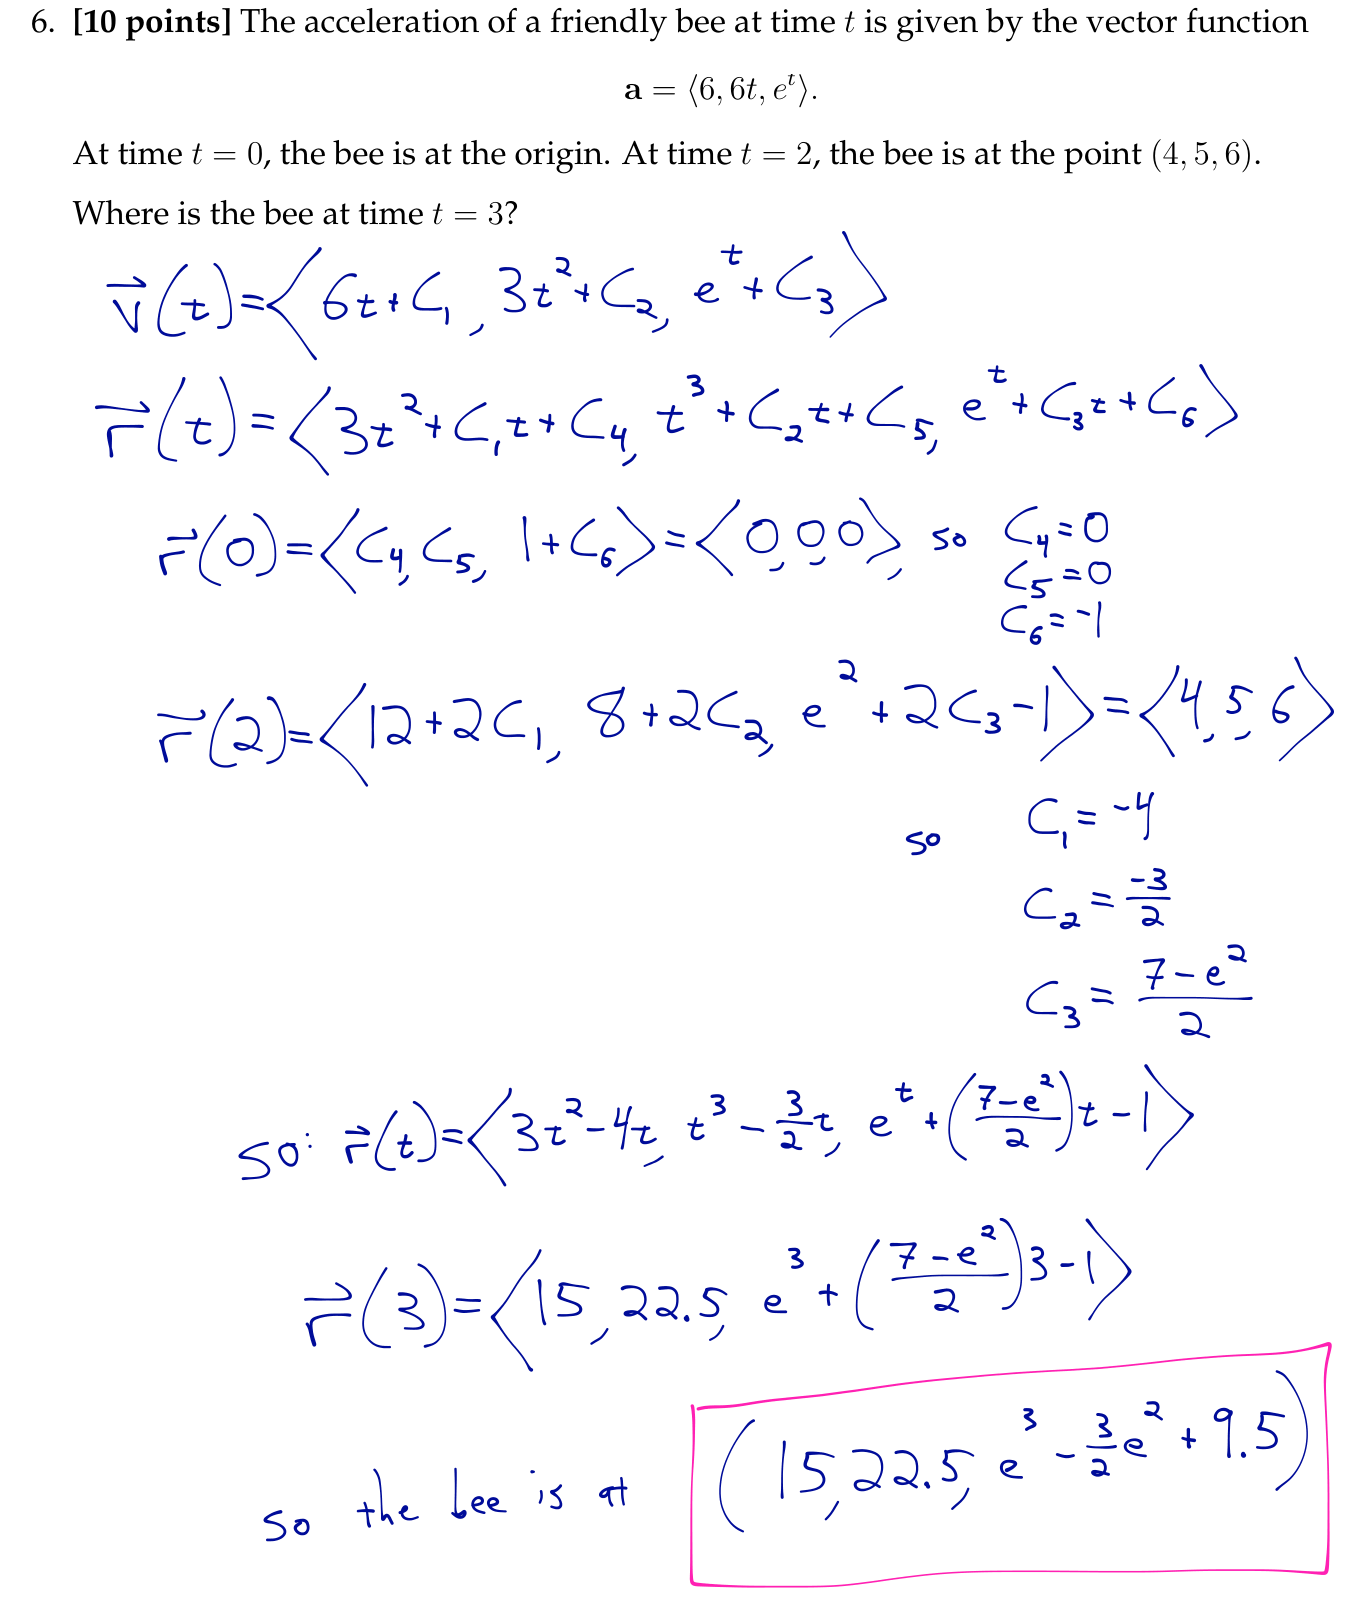
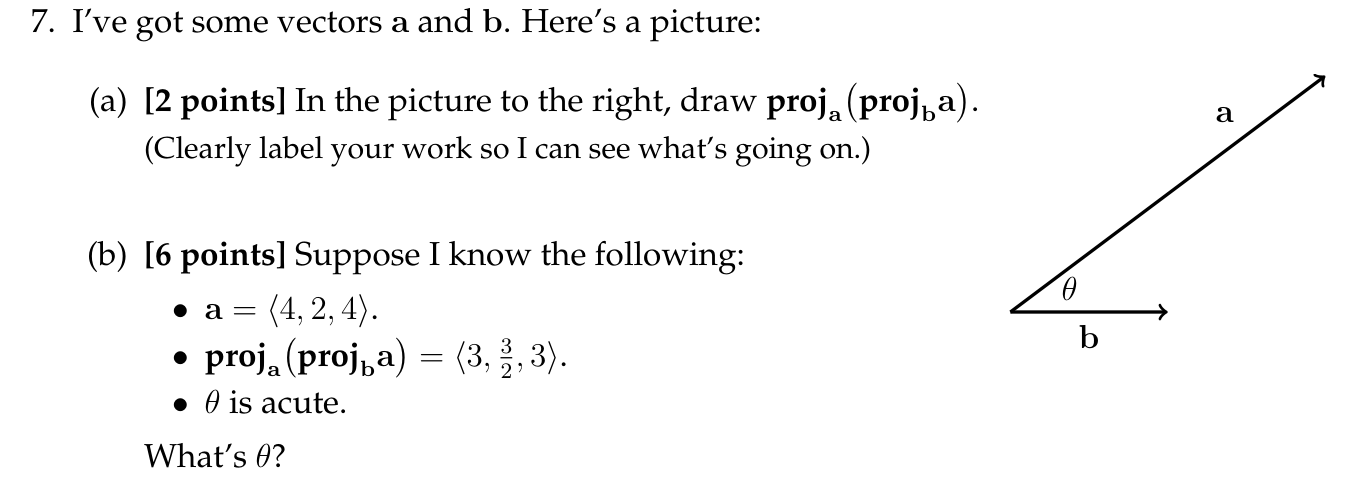
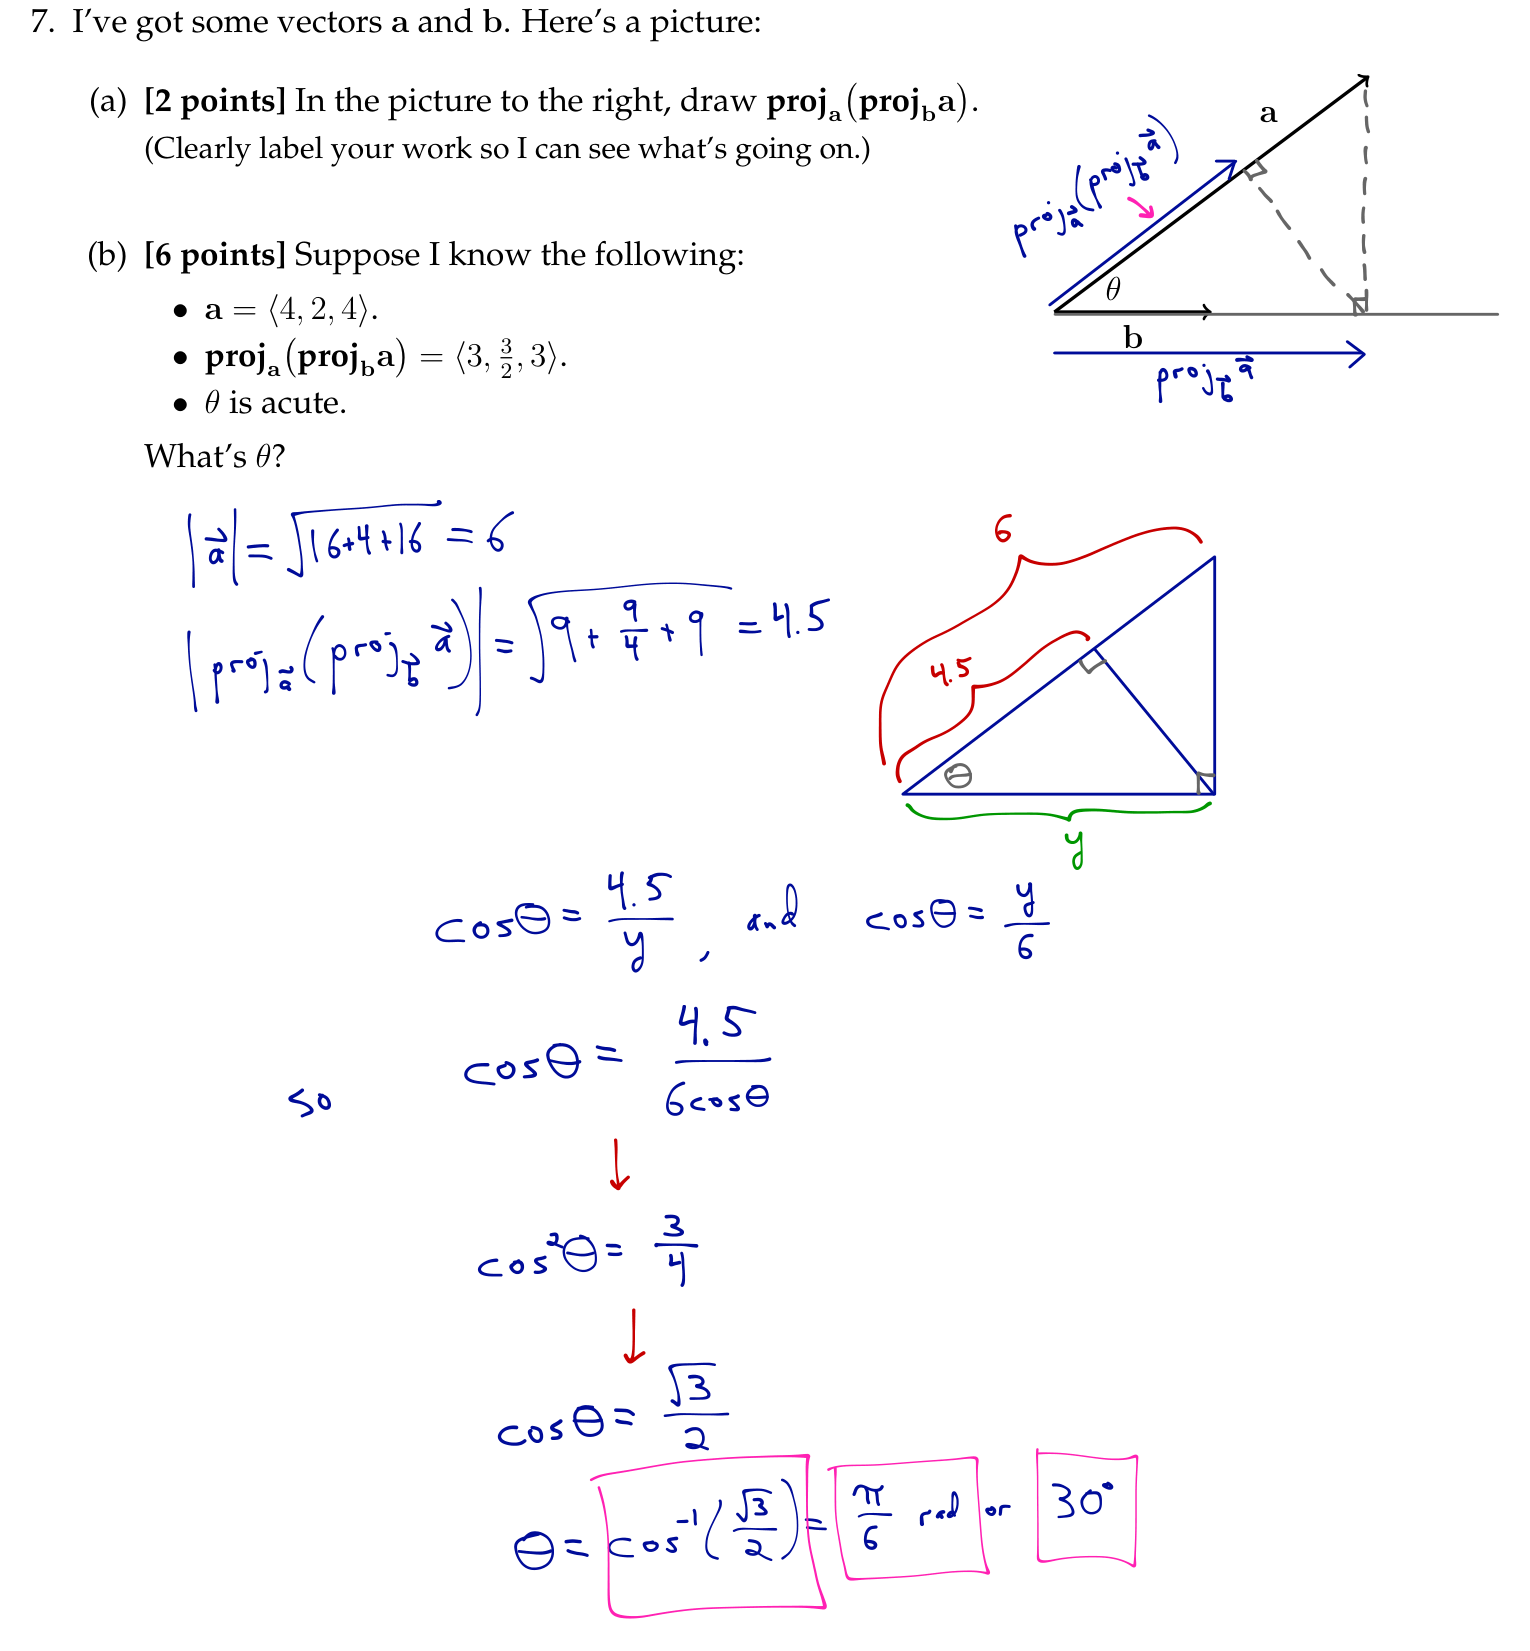

In [67]:
PROCESSED_DIR = Path("../data/processed")

def img_tag(p: Path, max_h=220):
    b = p.read_bytes()
    mime = "image/png"
    b64 = base64.b64encode(b).decode("ascii")
    return f'<img src="data:{mime};base64,{b64}" style="max-height:{max_h}px;">'

completed_tests = 0
completed_questions = 0

for test_path in PROCESSED_DIR.iterdir():
    test_id = test_path.name

    if (test_path / "Q1" / "metadata.json").exists():
        completed_tests += 1
        completed_questions += len(list(test_path.iterdir())) - 1
        continue
    else:
        print(f"{completed_tests} tests ({completed_questions} questions) already have metadatas.")
        print(f"Test ID: {test_id}")

        rows = []
        for q_dir in sorted(p for p in test_path.iterdir() if p.is_dir()):
            q = (q_dir / "question.png").resolve()
            a = (q_dir / "answer.png").resolve()

            rows.append(
                f"""
                <tr>
                  <td style="padding:8px; vertical-align:top; white-space:nowrap;">{q_dir.name}</td>
                  <td style="padding:8px;">{img_tag(q)}</td>
                  <td style="padding:8px;">{img_tag(a)}</td>
                </tr>
                """
            )

        html = f"""
        <div>
          <table border="0" cellspacing="0" cellpadding="0">
            <thead>
              <tr>
                <th style="text-align:left; padding:8px;">Q</th>
                <th style="text-align:left; padding:8px;">question.png</th>
                <th style="text-align:left; padding:8px;">answer.png</th>
              </tr>
            </thead>
            <tbody>
              {''.join(rows)}
            </tbody>
          </table>
        </div>
        """
        display(HTML(html))
        break

In [66]:
# happy and want to generate?
%run ../scripts/generate_question_metadatas -testId {test_id}

Generating question metadatas for test 5e6fa9c7-93f0-4a26-92bd-52aaa1a6e86b
Q1: ✅
Q2: ✅
Q3: ✅
Q4: ✅
Q5: ✅
Q6: ✅
Q7: ✅
Q8: ✅


In [64]:
# unhappy and want to edit?
os.startfile(test_path.resolve())

Common Problems (i.e. not enough cropping):
- What if a question is split across pages and the professor was kind enough to repeat the question/diagram on the second page?
- Long, horizontal lines at the bottom of pages
- Version 2's being attached to last answer
- Need to crop "DO NOT WRITE..."

In [42]:
# unhappy and want to delete?
shutil.rmtree(test_path)

Common Problems (i.e. wrong or too much cropping)
- What if a non-question page has 1., 2. ...?
- Answer key is not sectioned correctly while questions are! Usually a previous answer contains part of the next one.
- Part of question erased!
- Diagram of a question partially above number